In [523]:
import pandas as pd
import re
import string
import numpy as np
import json

def get_emb_matrix(target_i2w, w2v, EMB_DIM, unk_size=0.25, with_flags = True, oov_filename=None):
    emb_mat = np.zeros((len(target_i2w), EMB_DIM))
    notfound = []

    if with_flags:
        border = 2
    else:
        border = -1

    for i in target_i2w.keys():
        if i>border:
            if target_i2w[i] in w2v:
                emb_mat[i] = w2v[target_i2w[i]]
            else:
                notfound.append(target_i2w[i])
                #print(target_i2w[i], "not there!")
                emb_mat[i] = np.random.uniform(-unk_size, unk_size, EMB_DIM)

    if oov_filename is not None:
        with open(oov_filename, 'w') as fd:
            for i in notfound:
                fd.write(i+'\n')

    return emb_mat, notfound


def load_embs(embfile):
    with open(embfile,'r',encoding='utf8') as fd:
        t = fd.readlines()
    t = [i.strip() for i in t]
    t = [i.split(' ') for i in t]
    words = [i[0] for i in t]
    vecs = [i[1:] for i in t]
    vecs = [np.array([float(i) for i in vec]) for vec in vecs]
    D = dict(zip(words, vecs))
    return D

def write_dict_to_json(filename, D):
    print("Writing dictionary to "+filename)
    with open(filename, 'w', encoding='utf8') as f:
        f.write(json.dumps(D, sort_keys=True, indent=4))

def load_dict_from_json(filename):
    with open(filename,'r',encoding='utf8') as f:
        data = json.loads(f.read())
    return data


def load_data(filename, numlines=None, optional_processing=False, revert_tgt=False):#50000):
    """ filename: either str (name of file; the file must be a list of pairs
        in the form src \t tgt) or tuple (src, tgt).

        If numlines is None, load all the data.

        If optional_processing is True:
            - lowercase everything
            - remove punctuation

    """
    #filename = 'data-text/fra.txt'
    if isinstance(filename,str):
        lines = pd.read_table(filename, names=['src', 'tgt'])
        #print("Number of samples used from "+filename+": ",str(len(lines)) )
    elif isinstance(filename,tuple):
        s,t = load_two_files(*filename) # first is src, second is tgt.
        lines = pd.DataFrame({'src':s, 'tgt':t})
        #print("Number of samples used from "+", ".join(filename)+": ",str(len(lines)) )
    else:
        raise ValueError("Must be either name of the file or a tuple of filenames (src, tgt).")

    if numlines is not None:
        lines = lines[:numlines]


    if optional_processing:
        lines.src=lines.src.apply(lambda x: x.lower())
        lines.tgt=lines.tgt.apply(lambda x: x.lower())
        #lines.src=lines.src.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
        #lines.tgt=lines.tgt.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
        exclude = set(string.punctuation)
        lines.src=lines.src.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
        lines.tgt=lines.tgt.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    
    if revert_tgt:
        lines.tgt = lines.tgt.apply(lambda x : " ".join(x.split()[::-1]))
    lines.tgt = lines.tgt.apply(lambda x : 'START_ '+ x + ' _END')

    return lines


def load_two_files(src_file, tgt_file):
    with open(src_file,'r', encoding='utf8') as fd:
        src = fd.readlines()
    src = [i.strip() for i in src]

    with open(tgt_file,'r', encoding='utf8') as fd:
        tgt = fd.readlines()
    tgt = [i.strip() for i in tgt]

    return src, tgt

def get_max_sentence_lengths(lines):
    max_target_sentence = max([len(i.split()) for i in lines.tgt])
    max_source_sentence = max([len(i.split()) for i in lines.src])
    print("Max sequence length for inputs: ", max_source_sentence)
    print("Max sequence length for outputs: ", max_target_sentence)
    return max_source_sentence, max_target_sentence


def prepare_data_shared(lines):
    all_src_words=set()
    for src in lines.src:
        for word in src.split():
            if word not in all_src_words:
                all_src_words.add(word)

    all_tgt_words=set()
    for tgt in lines.tgt:
        for word in tgt.split():
            if word not in all_tgt_words:
                all_tgt_words.add(word)

    all_words = all_src_words | all_tgt_words
    all_words = all_words - {'START_'}
    #all_tgt_words = all_tgt_words - {'START_'}

    #input_words = sorted(list(all_src_words))
    target_words = ['START_']+sorted(list(all_words)) # want 'START_' to be the first

    #NOTE: want the first entry (0th) to correspond to the start symbol
    #input_w2i = dict(
    #    [(word, i) for i, word in enumerate(input_words)])
    target_w2i = dict(
        [(word, i) for i, word in enumerate(target_words)])

    input_w2i = target_w2i

    print("Target vocab size: ", len(target_w2i))
    print("Source vocab size: ", len(input_w2i))
    return input_w2i, target_w2i


def prepare_data(lines):
    all_src_words=set()
    for src in lines.src:
        for word in src.split():
            if word not in all_src_words:
                all_src_words.add(word)

    if 'START_' in all_src_words:
        print(0)

    all_tgt_words=set()
    for tgt in lines.tgt:
        for word in tgt.split():
            if word not in all_tgt_words:
                all_tgt_words.add(word)
    all_tgt_words = all_tgt_words - {'START_'}

    input_words = sorted(list(all_src_words))
    target_words = ["PAD", 'START_']+sorted(list(all_tgt_words))

    #NOTE: want the first entry (0th) to correspond to the start symbol
    input_w2i = dict(
        [(word, i) for i, word in enumerate(input_words)])
    target_w2i = dict(
        [(word, i) for i, word in enumerate(target_words)])

    print("Source vocab size: ", len(input_w2i))
    print("Target vocab size: ", len(target_w2i))

    return input_w2i, target_w2i


def encode_texts(input_texts, input_w2i, max_source_sentence):

    ##max_source_sentence = max([len(i.split()) for i in input_texts])

    encoder_input = np.zeros(
        (len(input_texts), max_source_sentence),
        dtype='float32')

    for i, input_text in enumerate(input_texts):
        for t, word in enumerate(input_text.split()):
            encoder_input[i, t] = input_w2i[word] #TODO get keyerror now.. what about OOV?

    return encoder_input


def get_encoder_and_decoder_arrays(input_w2i, target_w2i, max_source_sentence, max_target_sentence, lines):

    source_i2w = dict((i, word) for word,i in input_w2i.items())
    target_i2w = dict((i, word) for word,i in target_w2i.items())

    num_decoder_tokens = len(target_w2i)

    encoder_input_data = np.zeros(
        (len(lines.src), max_source_sentence),
        dtype='float32')

    decoder_input_data = np.zeros(
        (len(lines.tgt), max_target_sentence),
        dtype='float32')

    decoder_target_data = np.zeros(
        (len(lines.tgt), max_target_sentence, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(lines.src, lines.tgt)):
        for t, word in enumerate(input_text.split()):
            encoder_input_data[i, t] = input_w2i[word]

        for t, word in enumerate(target_text.split()):
            decoder_input_data[i, t] = target_w2i[word]
            if t > 0:
                # Teacher forcing.
                # Decoder_target_data is ahead of decoder_input_data by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_w2i[word]] = 1. # probability=1 on the known word.


    return encoder_input_data, decoder_input_data, decoder_target_data

In [102]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [524]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [399]:
logging.getLogger('tensorflow').setLevel(logging.DEBUG)  # suppress warnings

# Dataset

In [ ]:
!wget https://www.dropbox.com/s/ih5uqmxna4wponl/colab_data.zip?dl=1 -O colab_data.zip

In [ ]:
!unzip colab_data.zip

In [528]:
training_data_path_src = "./colab_data/verbs/src-path-train.txt"
training_data_path_tgt = "./colab_data/verbs/tgt-path-train.txt" 
validation_data_path_src = "./colab_data/verbs/src-path-valid.txt" 
validation_data_path_tgt = "./colab_data/verbs/tgt-path-valid.txt" 
test_data_path_src = "./colab_data/verbs/src-path-test.txt" 
test_data_path_tgt = "./colab_data/verbs/tgt-path-test.txt" 
src_emb_file = "./colab_data/ft-embs-all-lower.vec" 
tgt_emb_file = "./colab_data/ft-embs-all-lower.vec" 

In [529]:
embedding_size = 300
num_samples_train = None
num_samples_val = None

In [530]:
train_data = load_data((training_data_path_src, training_data_path_tgt), numlines=num_samples_train, revert_tgt=True)
val_data = load_data((validation_data_path_src, validation_data_path_tgt), numlines=num_samples_val, revert_tgt=True)
test_data = load_data((test_data_path_src, test_data_path_tgt), numlines=num_samples_val, revert_tgt=True)

#train_and_val = pd.concat([train_data, val_data], ignore_index=True)
train_and_val_and_test = pd.concat([train_data, val_data, test_data], ignore_index=True)

In [531]:
max_source_sentence_length, max_target_sentence_length = get_max_sentence_lengths(train_and_val_and_test)

Max sequence length for inputs:  1
Max sequence length for outputs:  13


In [532]:
input_w2i, target_w2i = prepare_data(train_and_val_and_test)
target_i2w = dict((i, word) for word,i in target_w2i.items())
# Only need this if using pretrained embeddings for encoder.
input_i2w = dict((i, word) for word,i in input_w2i.items())

num_unique_input_chars = len(input_w2i)
num_unique_target_chars = len(target_w2i)

if not os.path.exists('./word_models'):
        os.makedirs('./word_models')

if src_emb_file is not None:
    src_w2v = load_embs(src_emb_file)
    emb_matrix_src, src_OOV = get_emb_matrix(input_i2w, src_w2v, embedding_size, with_flags=False, oov_filename='word_models/src_oov.txt')
else:
    emb_matrix_src = None

if tgt_emb_file is not None:
    tgt_w2v = load_embs(tgt_emb_file)
    emb_matrix_tgt, tgt_OOV = get_emb_matrix(target_i2w, tgt_w2v, embedding_size, with_flags=True, oov_filename='word_models/tgt_oov.txt')
else:
    emb_matrix_tgt = None

Source vocab size:  7220
Target vocab size:  2087


In [533]:
def get_token_to_ind_arrays(input_w2i, target_w2i, max_source_sentence, max_target_sentence, lines):

    source_i2w = dict((i, word) for word,i in input_w2i.items())
    target_i2w = dict((i, word) for word,i in target_w2i.items())

    num_decoder_tokens = len(target_w2i)

    encoder_input_data = np.zeros(
        (len(lines.src), max_source_sentence),
        dtype='long')

    decoder_input_data = np.zeros(
        (len(lines.tgt), max_target_sentence),
        dtype='long')

    for i, (input_text, target_text) in enumerate(zip(lines.src, lines.tgt)):
        for t, word in enumerate(input_text.split()):
            encoder_input_data[i, t] = input_w2i[word]

        for t, word in enumerate(target_text.split()):
            decoder_input_data[i, t] = target_w2i[word]

    return encoder_input_data, decoder_input_data

In [534]:
x_train, y_train = get_token_to_ind_arrays(input_w2i, target_w2i, max_source_sentence_length, max_target_sentence_length, train_data)
x_val, y_val = get_token_to_ind_arrays(input_w2i, target_w2i, max_source_sentence_length, max_target_sentence_length, val_data)
x_test, y_test = get_token_to_ind_arrays(input_w2i, target_w2i, max_source_sentence_length, max_target_sentence_length, test_data)

In [535]:
train_examples = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_examples = tf.data.Dataset.from_tensor_slices((x_val, y_val))

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

This function will be used to encode the batches of raw text:

In [536]:
def tokenize_pairs(in_, out_):
    return in_, out_

In [579]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [538]:
def make_batches(ds):
    return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [539]:
for pt_examples, en_examples in train_batches.batch(1).take(1):
    for pt in pt_examples.numpy():
        print(pt.shape)
    for en in en_examples.numpy():
        print(en.shape)

(64, 1)
(64, 13)


In [540]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [541]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


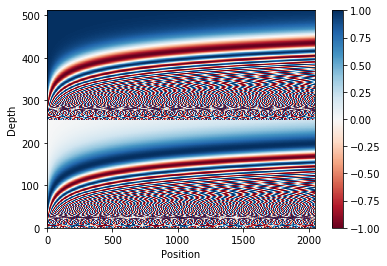

In [542]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Masking

In [543]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [544]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [545]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Multi-head attention

In [546]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [547]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Pointwise feed forward network

In [548]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [549]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

In [550]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [551]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [552]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [553]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [554]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, emb_matrix_src=None, trainable=False,rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        if emb_matrix_src is None:
            self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        else:
            self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, 
                                                       embeddings_initializer=tf.keras.initializers.Constant(emb_matrix_src),
                                                       trainable=trainable)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

In [555]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000,emb_matrix_src=None)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [556]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, emb_matrix_tgt=None, trainable=False, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        if emb_matrix_tgt is None:
            self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        else:
            self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, 
                                                       embeddings_initializer=tf.keras.initializers.Constant(emb_matrix_tgt),
                                                       trainable=trainable)
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [557]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000,emb_matrix_tgt=None)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

In [558]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, emb_matrix_src=None, emb_matrix_tgt=None,
               trainable_enc=False, trainable_dec=False, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, emb_matrix_src, trainable_enc, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, emb_matrix_tgt, trainable_dec, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [559]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

In [580]:
num_layers = 3
d_model = 300
dff = 512
num_heads = 4
dropout_rate = 0.1

## Optimizer 

In [581]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [582]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

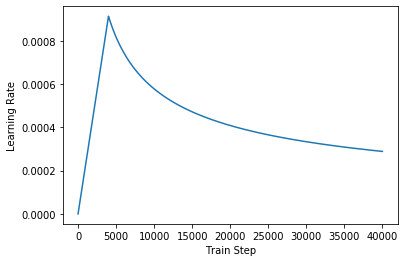

In [583]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [584]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [585]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [586]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [587]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(input_w2i),
    target_vocab_size=len(target_w2i), 
    pe_input=1000, 
    pe_target=1000,
    emb_matrix_src=emb_matrix_src,
    emb_matrix_tgt=emb_matrix_tgt,
    trainable_enc=False,
    trainable_dec=False,
    rate=dropout_rate)

In [588]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [589]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
#if ckpt_manager.latest_checkpoint:
    #ckpt.restore(ckpt_manager.latest_checkpoint)
    #print ('Latest checkpoint restored!!')

In [590]:
EPOCHS = 200

In [591]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [592]:
prev_best_loss=10000

with open('transformer_log.txt', "w") as logfile:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        # inp -> portuguese, tar -> english
        for (batch, (inp, tar)) in enumerate(train_batches):
            train_step(inp, tar)

            if batch % 50 == 0:
                str0 = f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}'
                print(str0)
                logfile.write(str0)
                logfile.write("\n")

        new_loss = train_loss.result()

        str1 = f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}'
        str2 = f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n'

        print(str1)
        print(str2)
        
        logfile.write(str1)
        logfile.write("\n")
        logfile.write(str2)
        logfile.write("\n")
        
        if new_loss < prev_best_loss:
            prev_best_loss = new_loss
            ckpt_save_path = ckpt_manager.save()
            str3 = f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}\n'
            print(str3)
            logfile.write(str3)
            logfile.write("\n")

        #if (epoch + 1) % 5 == 0:
            #ckpt_save_path = ckpt_manager.save()
            #str3 = 
            #print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

Epoch 1 Batch 0 Loss 7.8135 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.4942 Accuracy 0.0689
Epoch 1 Batch 100 Loss 6.9374 Accuracy 0.1719
Epoch 1 Loss 6.8766 Accuracy 0.1785
Time taken for 1 epoch: 26.76 secs

Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1

Epoch 2 Batch 0 Loss 5.9863 Accuracy 0.2678
Epoch 2 Batch 50 Loss 5.7668 Accuracy 0.2773
Epoch 2 Batch 100 Loss 5.6086 Accuracy 0.2768
Epoch 2 Loss 5.5867 Accuracy 0.2766
Time taken for 1 epoch: 12.31 secs

Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-2

Epoch 3 Batch 0 Loss 4.9405 Accuracy 0.3155
Epoch 3 Batch 50 Loss 5.0025 Accuracy 0.2855
Epoch 3 Batch 100 Loss 4.8656 Accuracy 0.2948
Epoch 3 Loss 4.8532 Accuracy 0.2953
Time taken for 1 epoch: 13.51 secs

Saving checkpoint for epoch 3 at ./checkpoints/train/ckpt-3

Epoch 4 Batch 0 Loss 4.4424 Accuracy 0.3276
Epoch 4 Batch 50 Loss 4.4341 Accuracy 0.3396
Epoch 4 Batch 100 Loss 4.3161 Accuracy 0.3567
Epoch 4 Loss 4.3079 Accuracy 0.3586
Time taken for 1 epoch: 1

## Evaluation

In [593]:
ckpt_manager.latest_checkpoint

'./checkpoints/train/ckpt-108'

In [594]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [595]:
test_examples = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [596]:
def evaluate(in_, max_length=20):
    encoder_input = in_
    encoder_input = tf.expand_dims(in_, 0)
    output = tf.convert_to_tensor([1])
    output = tf.expand_dims(output, 0)
    output = tf.cast(output, tf.int64)

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)
        
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == 2:
            break
    
    # output.shape (1, tokens)
    tokens = [target_i2w[i] for i in output[0].numpy()] # shape: ()
    return tokens, attention_weights

In [597]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')
    print(f'{"Ground truth":15s}: {ground_truth}')
  

In [598]:
count = 0
with open("in_transformer_predictions.tsv", 'w', encoding='utf-8') as f, open("out_transformer_predictions.tsv", 'w', encoding='utf-8') as w:
    for in_, out_ in test_examples:
        translated_tokens, attention_weights = evaluate(in_)
        f.write(input_i2w[in_.numpy()[0]]+"\n")
        w.write(" ".join([i for i in translated_tokens if i!="START_" and i!="_END" and i!="PAD"])+"\n")
        count += 1
        if count  <= 15:
            print_translation([input_i2w[i] for i in in_.numpy()], translated_tokens, [target_i2w[i] for i in out_.numpy() if i!=0])

Input:         : ['train.v.02']
Prediction     : ['START_', 'educate.v.01', 'better.v.02', 'change.v.01', '_END']
Ground truth   : ['START_', 'learn.v.04', '_END']
Input:         : ['double.v.01']
Prediction     : ['START_', 'reproduce.v.01', 'produce.v.02', '_END']
Ground truth   : ['START_', 'multiply.v.02', 'increase.v.02', 'change.v.01', '_END']
Input:         : ['whisper.v.01']
Prediction     : ['START_', 'utter.v.02', '_END']
Ground truth   : ['START_', 'talk.v.02', 'communicate.v.02', 'interact.v.01', 'act.v.01', '_END']
Input:         : ['evanesce.v.01']
Prediction     : ['START_', 'succeed.v.01', '_END']
Ground truth   : ['START_', 'disappear.v.01', '_END']
Input:         : ['transfer.v.04']
Prediction     : ['START_', 'change.v.01', '_END']
Ground truth   : ['START_', 'move.v.02', '_END']
Input:         : ['mutate.v.01']
Prediction     : ['START_', 'disappear.v.01', '_END']
Ground truth   : ['START_', 'change.v.02', '_END']
Input:         : ['pacify.v.01']
Prediction     : ['